In [549]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import os

In [550]:
path = os.getcwd() + "/BloodCells/"

In [551]:
def load_image(impath):
    image = cv2.imread(impath)
    return image

In [676]:
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_9649.jpeg"
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_9649.jpeg"
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_0_1095.jpeg"
#impath1 = path + "/images/TRAIN/NEUTROPHIL/_7_5840.jpeg"
# impath1 = path + "/images/TRAIN/NEUTROPHIL/_42_7923.jpeg"
impath1 = path + "/images/TRAIN/NEUTROPHIL/_12_8847.jpeg"

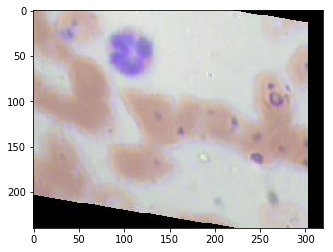

In [677]:
# Load an example image
imtest = load_image(impath1)
plt.imshow(cv2.cvtColor(imtest, cv2.COLOR_BGR2RGB))
plt.show()

In [679]:
# Efficient to find the darker zones in the image in order to crop on the cell of interest
def blurr(image, par1=30, par2=60):
    blurred = cv2.pyrMeanShiftFiltering(image, par1, par2)
    return blurred

0.020395


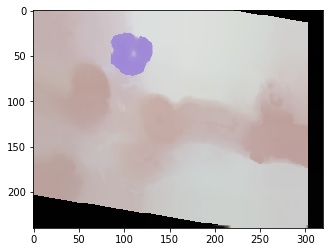

In [680]:
blurred = blurr(imtest)
start = time.clock()
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
end = time.clock()
print(end - start)

In [681]:
# Convert image to grayscale (easier to process)
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

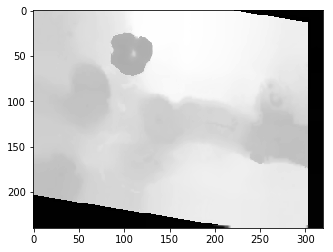

In [682]:
# Plot result of grayscale function
imgray = to_grayscale(blurred)
plt.imshow(imgray, "gray")

In [683]:
# Neutralize black frame by changing its color to average image color
def neutralize_frame(image, thresh=80):
    nonblack_avg = np.mean(image[image > thresh])
    image[image < thresh] = nonblack_avg

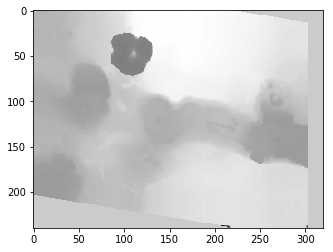

In [684]:
# Test neutralize frame function and plot the result
neutralize_frame(imgray)
plt.imshow(imgray, "gray")

In [685]:
np.percentile(imgray, 2)

157.0

In [686]:
# Find the darker regions
def thresholding(image, pth=2):
    percentile = int(np.percentile(image, pth))
    ret, thr = cv2.threshold(image, percentile, 255, cv2.THRESH_BINARY)
    return thr

In [687]:
# Take the negative of the image
def invert(image) :
    inverted = -(image - 255)
    return inverted

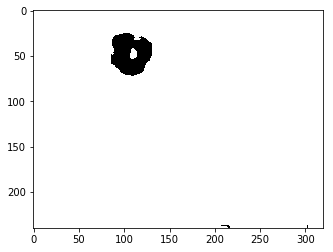

In [688]:
# Threshold the image to locate the darker zones corresponding to the cell we are trying to identify
thresholded = thresholding(imgray)
plt.imshow(thresholded, "gray")

In [689]:
# Filter out remaining noise (some isolated black pixels remain)
def noise_filtering(image, kernel_size=5):
    neg = invert(image)
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    closing = cv2.morphologyEx(neg, cv2.MORPH_OPEN, kernel)
    return invert(closing)

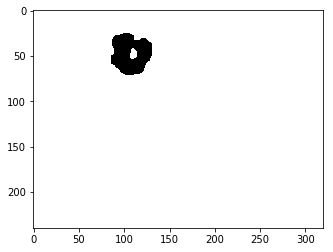

In [690]:
closing = noise_filtering(thresholded)
plt.imshow(closing, "gray")

In [691]:
# We take the average index from the non white-pixels to estimate the center of the cell we are trying to identify
def find_centre(threshim):
    centre = np.mean(np.argwhere(threshim != 255), axis=0).astype(int)
    return centre

In [692]:
# Test find center function
centre = find_centre(closing)
print(centre)

[ 47 107]


In [693]:
# Reframe the image with npixs in each dimension around the center
def focus_on_centre(image, centre, npixs=150):
    limx = image.shape[0]
    limy = image.shape[1]
    if centre[0] - npixs//2 < 0:
        ax0 = 0
        ax1 = npixs
    elif centre[0] + npixs//2 > limx:
        ax0 = limx - npixs
        ax1 = limx
    else :
        ax0 = centre[0] - npixs//2
        ax1 = centre[0] + npixs//2
    if centre[1] - npixs//2 < 0:
        ay0 = 0
        ay1 = npixs
    elif centre[1] + npixs//2 > limy:
        ay0 = limy - npixs
        ay1 = limy
    else :
        ay0 = centre[1] - npixs//2
        ay1 = centre[1] + npixs//2
    if len(image.shape) == 3:
        return image[ax0 : ax1, ay0 : ay1, :]
    else :
        return image[ax0 : ax1, ay0 : ay1]

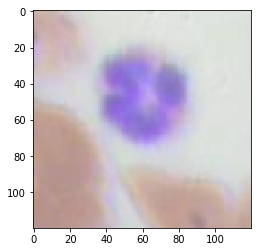

In [694]:
# Test focus on center function
npixs = 120
imreduced = focus_on_centre(imtest, centre, npixs)
plt.imshow(cv2.cvtColor(imreduced, cv2.COLOR_BGR2RGB))

In [695]:
imreduced.shape

(120, 120, 3)

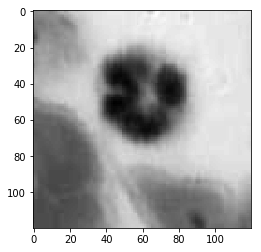

In [696]:
# We use grayscale version to simplify the problem and to be able to vectorize images
reduced_gray = to_grayscale(imreduced)
neutralize_frame(reduced_gray)
plt.imshow(reduced_gray, "gray")

In [697]:
# 
def to_normalized_negative(image):
    inverted = invert(image).astype(float)
    normalized = (1.0 / 255.0) * inverted
    return normalized

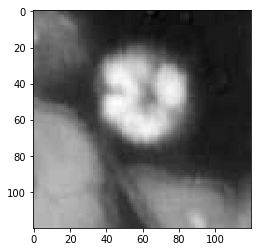

In [698]:
negative = to_normalized_negative(reduced_gray)
plt.imshow(negative, "gray")

In [699]:
def centre_image(image, frame_thresh=80, pth=2, npixs=120):
    blurred = blurr(image)
    imgray = to_grayscale(blurred)
    neutralize_frame(imgray, frame_thresh)
    thresholded = thresholding(imgray, pth)
    closing = noise_filtering(thresholded)
    centre = find_centre(closing)
    imreduced = to_grayscale(focus_on_centre(image, centre, npixs))
    neutralize_frame(imreduced, frame_thresh)
    negative = to_normalized_negative(imreduced)
    return negative

In [700]:
def to_1d(image):
    return image.flatten()

In [701]:
def to_2d(vecimage):
    s = int(np.sqrt(vecimage.shape[0]))
    return vecimage.reshape(s, s)

In [702]:
start = time.clock()
neg = centre_image(imtest)
end = time.clock()
print(end - start)

0.299878


In [703]:
to_1d(neg)

array([ 0.2627451 ,  0.27843137,  0.2745098 , ...,  0.34509804,
        0.33333333,  0.32941176])

In [466]:
to_2d(to_1d(neg))

array([[ 0.12156863,  0.1254902 ,  0.12941176, ...,  0.30980392,
         0.30588235,  0.30196078],
       [ 0.12156863,  0.1254902 ,  0.12941176, ...,  0.31764706,
         0.31372549,  0.31372549],
       [ 0.1254902 ,  0.1254902 ,  0.12941176, ...,  0.32941176,
         0.3254902 ,  0.3254902 ],
       ..., 
       [ 0.09411765,  0.09411765,  0.09411765, ...,  0.22352941,
         0.22352941,  0.22352941],
       [ 0.09411765,  0.09411765,  0.09411765, ...,  0.22352941,
         0.22352941,  0.22352941],
       [ 0.09411765,  0.09411765,  0.09411765, ...,  0.22352941,
         0.22352941,  0.22352941]])

In [467]:
path_neutrophil = path + "/images/TRAIN/NEUTROPHIL/"
path_lymphocyte = path + "/images/TRAIN/LYMPHOCYTE/"

In [704]:
def process_all_directory(dirpath, frame_thresh=80, pth=2, npixs=150, imax=10):
    files = os.listdir(dirpath)
    nfiles = len(files)
    stacked = np.zeros((npixs ** 2, nfiles))
    i = 0
    while i < imax :
        image = load_image(dirpath + files[i])
        print(files[i])
        print(image.shape)
        stacked[:, i] = to_1d(centre_image(image, frame_thresh, pth, npixs))
        print(i)
        i += 1
    return stacked

In [705]:
start = time.clock()
neutrophils = process_all_directory(path_neutrophil, npixs=120)
end = time.clock()
print(end - start)

_12_8847.jpeg
(240, 320, 3)
0
_42_7923.jpeg
(240, 320, 3)
1
_126_6127.jpeg
(240, 320, 3)
2
_37_1354.jpeg
(240, 320, 3)
3
_130_406.jpeg
(240, 320, 3)
4
_104_3511.jpeg
(240, 320, 3)
5
_148_9434.jpeg
(240, 320, 3)
6
_6_6019.jpeg
(240, 320, 3)
7
_93_5386.jpeg
(240, 320, 3)
8
_99_8689.jpeg
(240, 320, 3)
9
2.931675


In [171]:
start = time.clock()
lymphocytes = process_all_directory(path_lymphocyte)
end = time.clock()
print(end - start)

3.235927


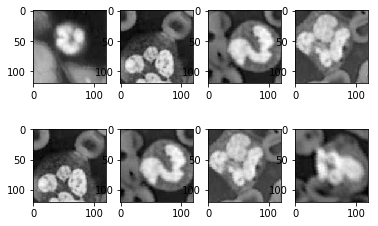

In [708]:
fig, axes = plt.subplots(2, 4)
for i in range(0, 4):
    for j in range(0, 2):
        axes[j, i].imshow(to_2d(neutrophils[:, i+j]), "gray")